---

## **<font color="Dodgerblue"> Modelación Climática Tropical</font>**
### **<font color="crimson"> Regresión lineal para la precipitación en JJAS con SPEAR (solo temporal)</font>**

---

In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install netCDF4 

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install h5py netCDF4 h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [7]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.util import add_cyclic_point
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import matplotlib.ticker as ticker
import glob
from scipy import stats
from scipy.stats import t

In [8]:
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel(ylab,fontsize=14)
    plt.title(title,fontsize=15)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=9)

In [9]:
def mapa_MC(data, levels, ccmap, titulo, extend='max', cbarlabel='Coeficiente de regresión', 
            limite_NS=75, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    lons, lats = data.lon, data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    fig = plt.figure(figsize=(12, 11))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cs = ax.contourf(lon, lats, data, levels=levels, cmap=ccmap, extend=extend, transform=ccrs.PlateCarree())

    # Definimos la extensión del mapa
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([0, 359.1, -limite_NS, limite_NS], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    plt.title(titulo, fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    # agregar colorbar
    cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.046, pad=0.06)
    cbar.ax.xaxis.label.set_size(18)  
    cbar.ax.tick_params(labelsize=17)  
    cbar.ax.set_xlabel(cbarlabel)

In [10]:
# Archivo de precipitación SPEAR - un miembro del ensamble
filename='/home/jovyan/ModClim/SPEAR3/monthly_ens001.nc'
ds=xr.open_dataset(filename)
pr=ds['precip']
pr

<xarray.DataArray 'precip' (time: 1080, lat: 90, lon: 104)> Size: 40MB
[10108800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 9kB 1921-01-16T12:00:00 ... 2010-12-16T12:...
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
Attributes:
    long_name:      Total precipitation rate
    units:          kg/m2/s
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1

In [11]:
# Convertimos unidades
pr=pr*86400
pr['units']='mm day-1'

In [12]:
pr_years = pr.sel(time=slice('1921', '2010'))

In [13]:
jjas = pr_years.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)

In [14]:
mean_jjas = jjas.mean('time')

### **<font color="Navy"> Serie de tiempo del promedio de área de las precipitaciones sobre México </font>**


In [15]:
# Asignamos pesos con la función coseno
lats = jjas.lat
weights = np.cos(np.deg2rad(lats))
weights.name = "weights"

In [16]:
# Aplicamos el peso y luego el promedio espacial
pr_weighted = jjas.weighted(weights)
pr_meanglobal = pr_weighted.mean(dim=['lat', 'lon'])

In [17]:
# Recorte de México
centrolat=jjas.sel(lat=slice(9.25,33.25))
centrolon=centrolat.sel(lon=slice(242.75,275.75))

centro_peso=centrolon.weighted(weights)
prcentro=centrolon.mean(["lon","lat"])

pr_annual2=prcentro.resample(time='1Y').mean() # resampleamos a escala anual
#pr_annual2.to_netcdf('SPEAR_serie.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


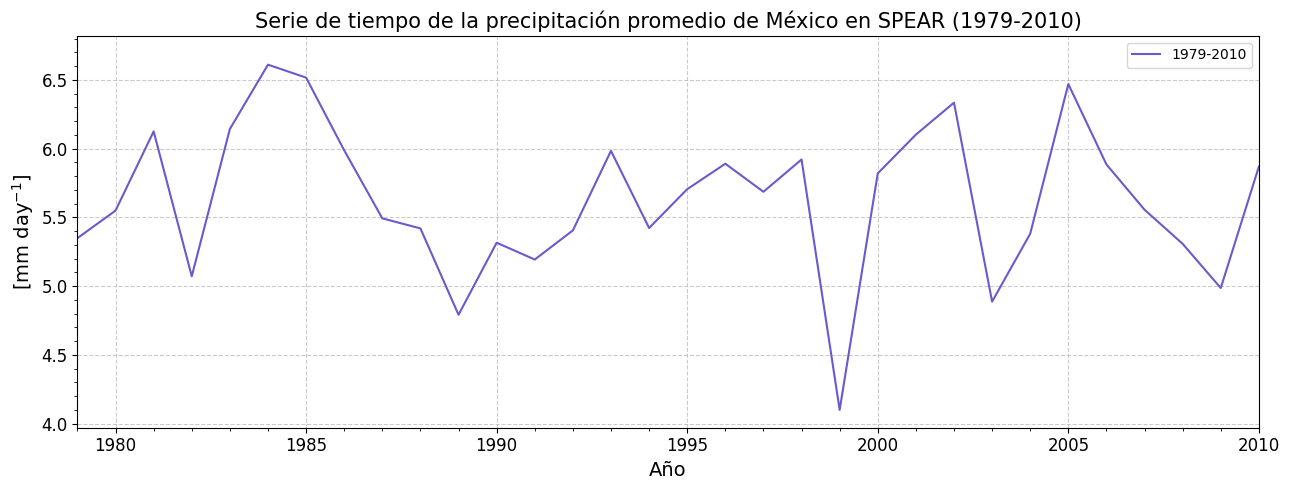

In [18]:
plt.figure(figsize=(13,5))
plt.plot(pr_annual2.time.dt.year,pr_annual2,c='slateblue',label='1979-2010') 
lineplot_setup(1979,2010,'Año','[mm day$^{-1}$]',title='Serie de tiempo de la precipitación promedio de México en SPEAR (1979-2010)')
plt.legend()
plt.tight_layout()

In [19]:
# Para generar automaticamente la lista de archivos sin tener que escribirlos
file_list = np.sort(glob.glob("/home/jovyan/ModClim/SPEAR/monthly*ens*.nc"))
print(file_list)

['/home/jovyan/ModClim/SPEAR/monthly_ens001.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens002.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens003.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens004.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens005.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens006.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens007.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens008.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens009.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens010.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens011.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens012.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens013.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens014.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens015.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens016.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens017.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens018.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens019.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens020.nc'
 '/home/jovyan/ModClim/SPEAR/monthly_ens

In [20]:
# Generamos una lista para almacenar las climatologías
ens_dlist = []

# Ciclo para cada miembro
for i, filename in enumerate(file_list):
    ds = xr.open_dataset(filename)
    pr = ds['precip'] * 86400  
    pr['units'] = 'mm day-1'

    # Selección de periodo Completo
    pr_years=pr.sel(time=slice('1921', '2010'))
    pr_jjas = pr_years.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)

    pr_jjas = pr_jjas.assign_coords(ens=i + 1)
    ens_dlist.append(pr_jjas)
    
    # Append a la lista que hicimos
ens_combined = xr.concat(ens_dlist, dim='ens')
print(ens_combined)

# Concatena los miembros en la dimensión ensamble
ens_mean = ens_combined.mean(dim='ens')

<xarray.DataArray 'precip' (ens: 30, time: 360, lat: 90, lon: 104)> Size: 404MB
array([[[[ 0.23055   ,  0.19597673,  0.15402772, ..., 14.221833  ,
           8.751894  ,  4.7008224 ],
         [ 0.17870091,  0.1687568 ,  0.13877204, ..., 12.587558  ,
           9.740463  ,  7.553781  ],
         [ 0.14594315,  0.1406652 ,  0.12606521, ..., 12.00389   ,
          12.202474  , 11.282138  ],
         ...,
         [ 1.3080932 ,  1.9023124 ,  2.124213  , ...,  6.920149  ,
           6.985851  ,  6.7509527 ],
         [ 1.1259725 ,  1.6561557 ,  2.2878475 , ...,  5.6570787 ,
           5.795901  ,  6.036526  ],
         [ 1.015633  ,  1.4812825 ,  1.9912394 , ...,  5.023547  ,
           5.1749787 ,  5.2351737 ]],

        [[ 0.22798759,  0.22183172,  0.21115436, ...,  9.086072  ,
          12.243313  , 10.901846  ],
         [ 0.1881542 ,  0.19442214,  0.18841015, ...,  9.922695  ,
          12.6967    , 12.858673  ],
         [ 0.19170591,  0.19291337,  0.20159353, ..., 10.852235  ,
     

In [21]:
# Recortamos el promedio a la zona de estudio
area_ens = ens_mean.sel(lat=slice(13.75, 23.75), lon=slice(253.75, 273.5))
mean_annual = area_ens.groupby('time.year').mean(dim='time')

In [22]:
mean_precipitation_ensemble = mean_annual.mean(dim=['lat', 'lon']).values

In [23]:
years = mean_annual['year'].values

In [24]:
# Serie de tiempo, en donde X son los años, y es la precipitación promedio
X = years
y = mean_precipitation_ensemble
#np.save('serie_pr_SPEAR_21.npy',y)

# Para calcular la pendiente (m) y la intersección (b)
m = np.sum((X - np.mean(X)) * (y - np.mean(y))) / np.sum((X - np.mean(X))**2)
b = np.mean(y) - m * np.mean(X)
m_siglo=m*100 # Multiplicamos por siglo
m_siglo
#np.save('pendiente_SPEAR_ens_1921.npy',m_siglo)

# Calculamos las predicciones. Ec. de regresión lineal simple
predicciones = b + m * X
#np.save('predicciones_SPEAR_ens_1921.npy',predicciones)

print(m_siglo)

0.0745355950935773


In [25]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [26]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Hacemos la prueba con Ordinary Least Squares - obtenido de: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html 
X_inter = sm.add_constant(X)  
modelo = sm.OLS(y, X_inter).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.086
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.300
Time:                        03:51:37   Log-Likelihood:                 29.538
No. Observations:                  90   AIC:                            -55.08
Df Residuals:                      88   BIC:                            -50.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0168      1.406      3.569      0.0

In [28]:
# Hacemos la prueba de Bresuch-Pagan, obtenida de: https://www.statology.org/breusch-pagan-test-python/
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(modelo.resid, modelo.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', np.float64(0.027914835822603346)),
 ('p-value', np.float64(0.8673091994941577)),
 ('f-value', np.float64(0.027302974560456474)),
 ('f p-value', np.float64(0.869137133938172))]

In [29]:
res1 = stats.linregress(X, y)
print(res1)

LinregressResult(slope=np.float64(0.0007453559509357729), intercept=np.float64(5.0168229849420864), rvalue=np.float64(0.11043284985749041), pvalue=np.float64(0.30011506741544053), stderr=np.float64(0.0007150882242068834), intercept_stderr=np.float64(1.405628673410074))


In [30]:
# Otro modo de imprimir el pvalue
print(f"P-valor: {res1.pvalue:.5f}")

P-valor: 0.30012


In [31]:
# Hacemos otro ciclo diferente para calcular los del periodo reciente
ens_dlist = []

# Ciclo para cada miembro
for i, filename in enumerate(file_list):
    ds = xr.open_dataset(filename)
    pr = ds['precip'] * 86400  
    pr['units'] = 'mm day-1'

    # Selección de verano durante el periodo reciente
    pr_years=pr.sel(time=slice('1980', '2010'))
    pr_jjas = pr_years.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)

    pr_jjas = pr_jjas.assign_coords(ens=i + 1)
    ens_dlist.append(pr_jjas)
    
    # Append los datos a la lista
ens_combined = xr.concat(ens_dlist, dim='ens')
print(ens_combined)

# Concatena en la dimensión del ensamble
ens_mean2 = ens_combined.mean(dim='ens')

<xarray.DataArray 'precip' (ens: 30, time: 124, lat: 90, lon: 104)> Size: 139MB
array([[[[ 0.3105119 ,  0.30919513,  0.3042074 , ...,  7.5636992 ,
           5.9965076 ,  3.622634  ],
         [ 0.27155435,  0.26371098,  0.26977918, ...,  8.700423  ,
           6.670884  ,  4.1860495 ],
         [ 0.25998977,  0.24630693,  0.25352648, ...,  8.865246  ,
           7.8806357 ,  3.7267838 ],
         ...,
         [ 2.2127275 ,  3.3116136 ,  4.118185  , ...,  4.2209206 ,
           4.086631  ,  3.6991665 ],
         [ 1.5890135 ,  2.4290853 ,  3.8041646 , ...,  4.0296187 ,
           3.9055624 ,  3.6128283 ],
         [ 1.269207  ,  1.9695392 ,  2.8774643 , ...,  3.6964366 ,
           3.836139  ,  3.7693894 ]],

        [[ 0.13993429,  0.14175801,  0.11414729, ...,  1.6054577 ,
           1.5571458 ,  1.5586638 ],
         [ 0.14670886,  0.15721141,  0.1369917 , ...,  1.7246947 ,
           1.367789  ,  1.3952038 ],
         [ 0.15723962,  0.16542192,  0.16124693, ...,  1.7828562 ,
     

In [32]:
# Recortamos el centro-sur 
area_ens_2 = ens_mean2.sel(lat=slice(13.75, 23.75), lon=slice(253.75, 273.5))
mean_annual_2 = area_ens_2.groupby('time.year').mean(dim='time')

In [33]:
mean_precipitation_ensemble_2 = mean_annual_2.mean(dim=['lat', 'lon']).values

In [34]:
years_2 = mean_annual_2['year'].values

In [35]:
# Serie de tiempo
X2 = years_2
y2 = mean_precipitation_ensemble_2
#np.save('serie_pr_SPEAR_1980.npy',y2)

# Calculamos la pendiente (m) y la intersección (b)
m2 = np.sum((X2 - np.mean(X2)) * (y2 - np.mean(y2))) / np.sum((X2 - np.mean(X2))**2)
b2 = np.mean(y2) - m2 * np.mean(X2)
m2_siglo=m2*100
m2_siglo
#np.save('pendiente_SPEAR_ens_1980.npy',m2_siglo)

# Calcular las predicciones 
predicciones2 = b2 + m2 * X2
#np.save('predicciones_SPEAR_ens_1980.npy',predicciones2)
print(m2_siglo)

0.10564802154417961


In [36]:
# Hacemos la prueba con Ordinary Least Squares - obtenido de: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html 
X_inter_2 = sm.add_constant(X2)  
modelo_reciente = sm.OLS(y2, X_inter_2).fit()
print(modelo_reciente.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                   0.08116
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.778
Time:                        03:51:40   Log-Likelihood:                 9.4106
No. Observations:                  31   AIC:                            -14.82
Df Residuals:                      29   BIC:                            -11.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3914      7.398      0.594      0.5

In [37]:
# Hacemos la prueba de Bresuch-Pagan, obtenida de: https://www.statology.org/breusch-pagan-test-python/
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(modelo_reciente.resid, modelo_reciente.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', np.float64(0.004157102313626204)),
 ('p-value', np.float64(0.9485915392666976)),
 ('f-value', np.float64(0.0038894237363743403)),
 ('f p-value', np.float64(0.9506998352341604))]

In [38]:
res = stats.linregress(X2, y2)
print(res)

LinregressResult(slope=np.float64(0.0010564802154417962), intercept=np.float64(4.391444112985365), rvalue=np.float64(0.052829291893479326), pvalue=np.float64(0.7777513620799351), stderr=np.float64(0.0037083497627667878), intercept_stderr=np.float64(7.398232129223564))


In [39]:
# Imprimimos el pvalue de otro modo
print(f"P-valor: {res.pvalue:.5f}")

P-valor: 0.77775


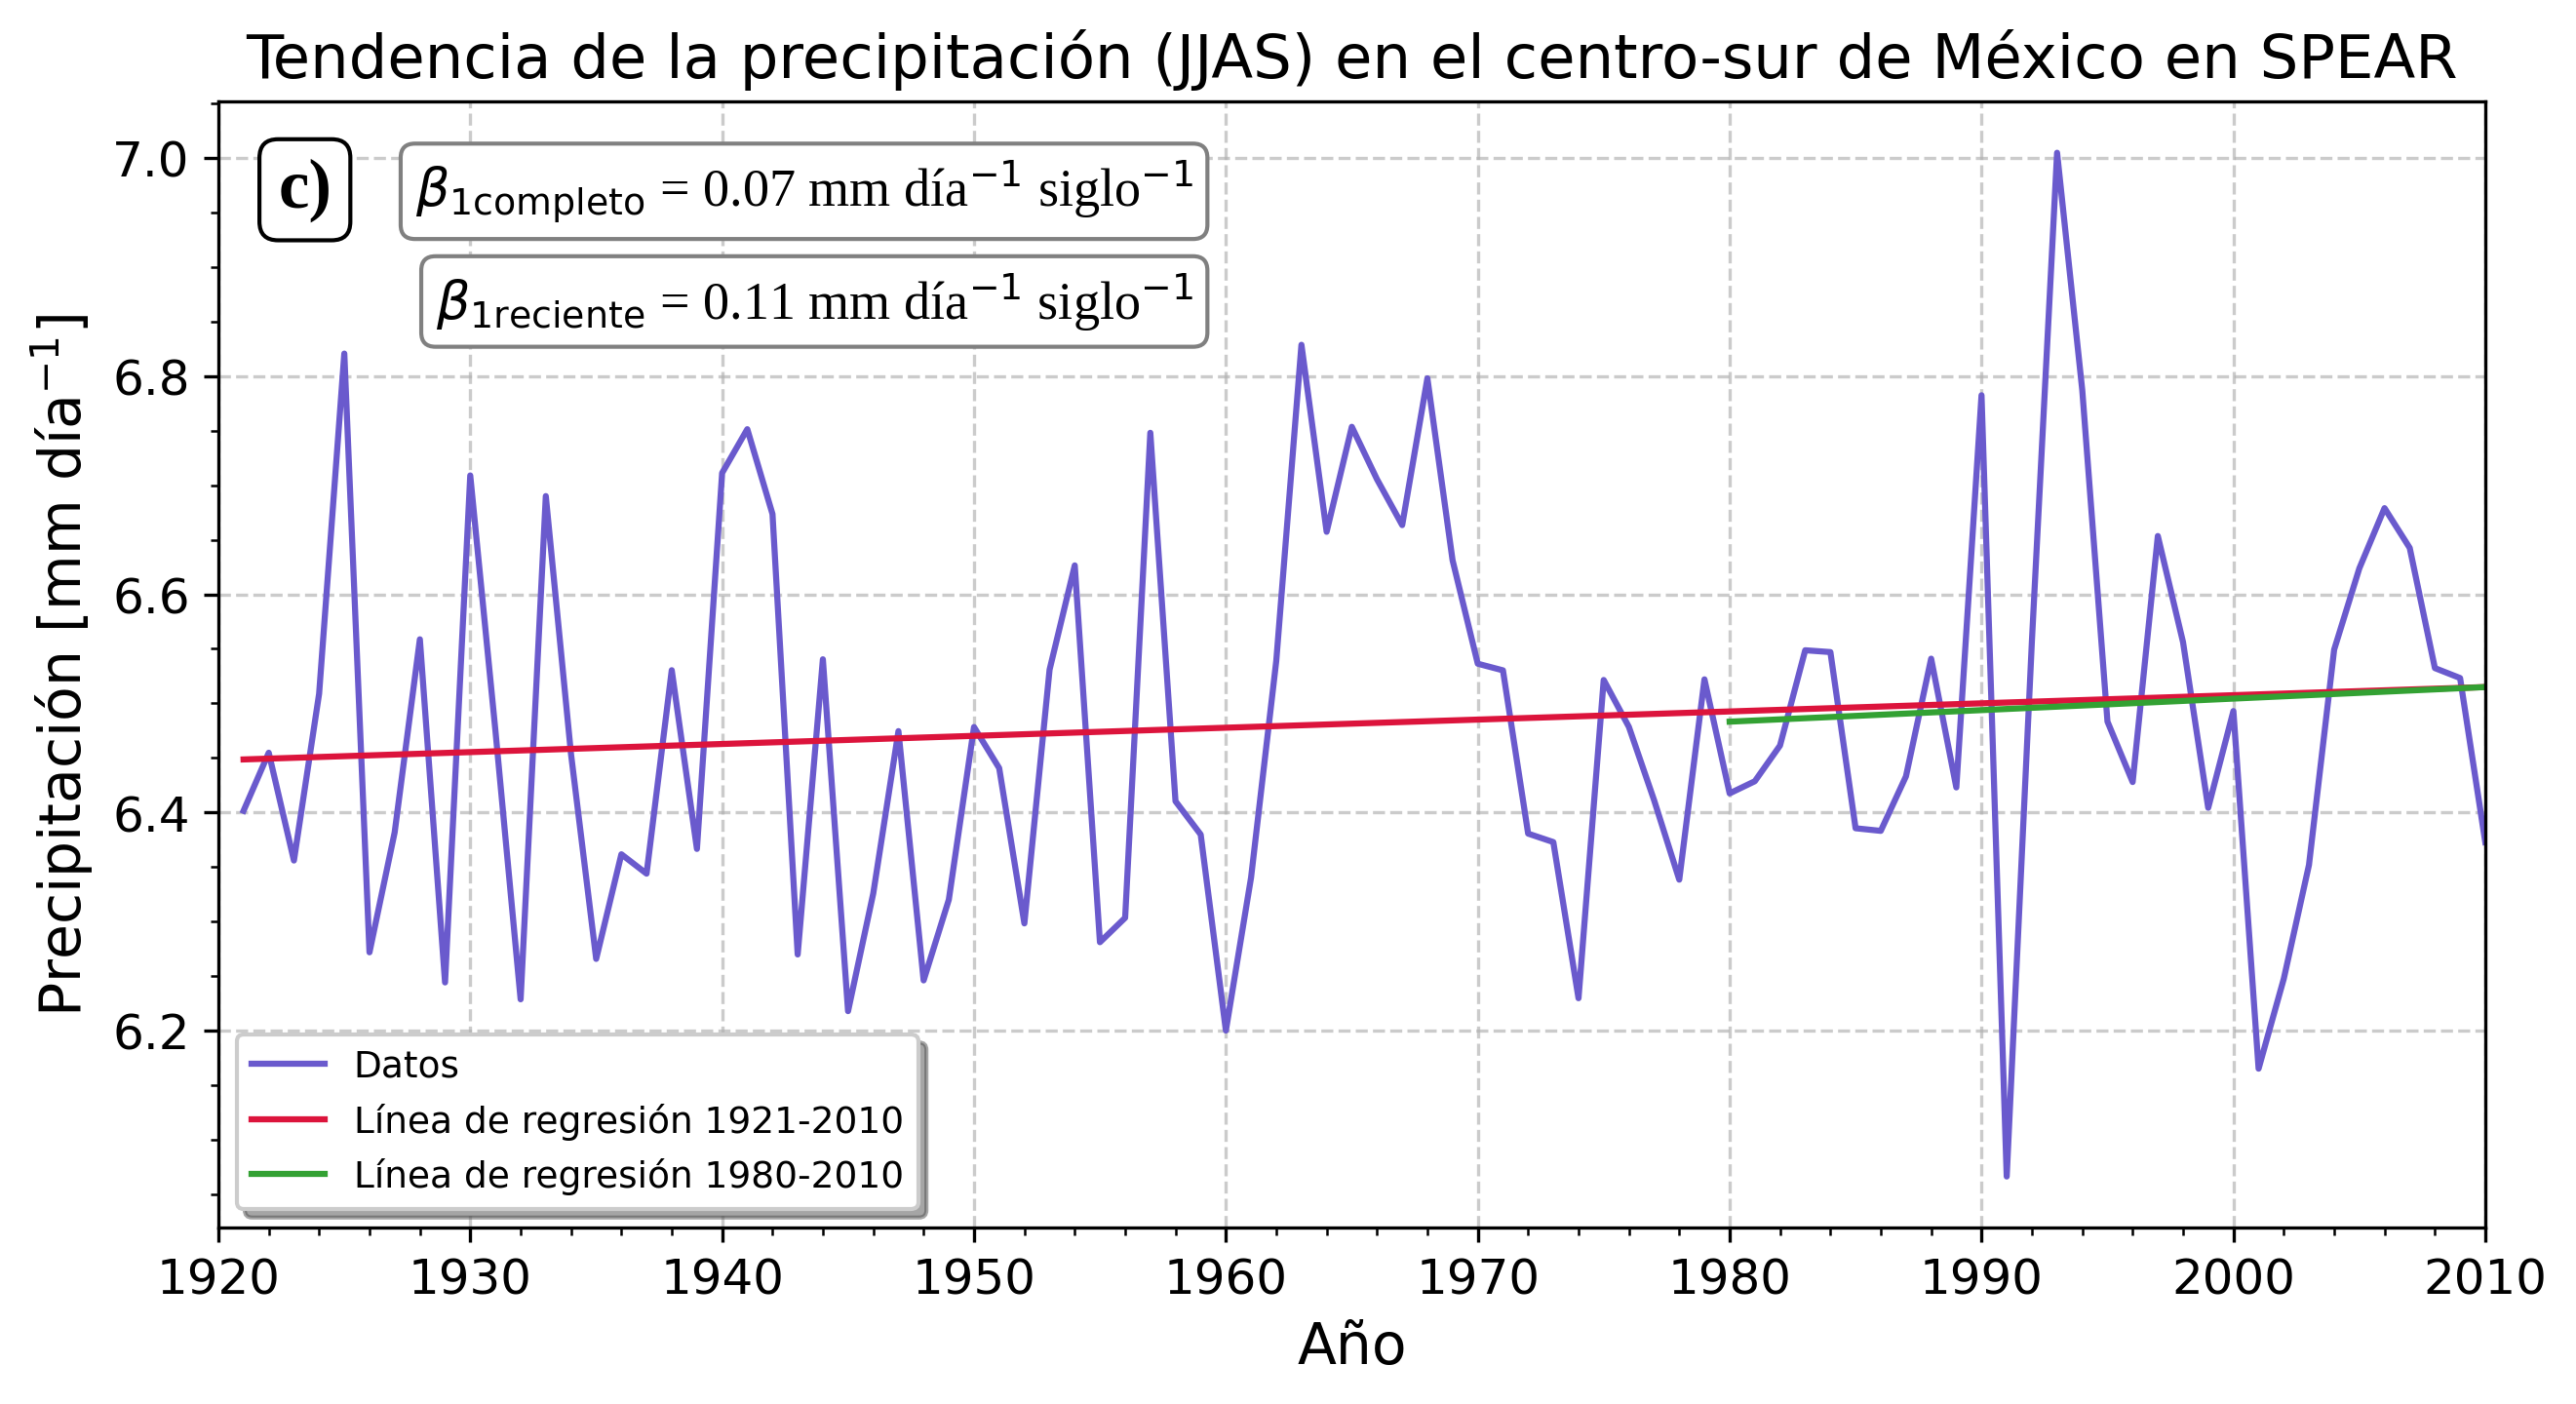

In [40]:
# Graficamos los datos y la línea de regresión 
plt.figure(figsize=(10,5), dpi=300)
plt.plot(X, y, color='slateblue', label='Datos')
#plt.plot(X2, y2, color='slateblue', label='Datos')
plt.plot(X, predicciones, color='crimson', label='Línea de regresión 1921-2010')
plt.plot(X2, predicciones2, color='#33a133', label='Línea de regresión 1980-2010')
plt.text(0.05, 0.95, 'c)', transform=plt.gca().transAxes, fontsize=17, fontname='Liberation Serif', fontweight='bold', va='top', ha='right',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.27', linewidth=1))
lineplot_setup(1920,2010,'Año','Precipitación [mm día$^{-1}$]',title='Tendencia de la precipitación (JJAS) en el centro-sur de México en SPEAR',legend=True)

plt.text(0.43, 0.95, r'$\beta_{\mathrm{1 completo}}$ = 0.07 mm día$^{-1}$ siglo$^{-1}$', transform=plt.gca().transAxes, fontsize=13, fontname='Liberation Serif', fontweight='normal', va='top', ha='right',
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.27', linewidth=1))

plt.text(0.43, 0.85, r'$\beta_{\mathrm{1 reciente}}$ = 0.11 mm día$^{-1}$ siglo$^{-1}$', transform=plt.gca().transAxes, fontsize=13, fontname='Liberation Serif', fontweight='normal', va='top', ha='right',
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.27', linewidth=1))

ax = plt.gca()  
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))  # Intervalo de 0.5 en 0.5